In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from functions import *

# 1 Folder Data loading
The code is loading multiple CSV files from a specified folder path and converting them into pandas DataFrames.

In [12]:
folder_path = "data/e production=ep sanyo ep sanyo 004"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

dataframes = []
dfarrnames = []

# Loop through the CSV files and load only those ending with "Format01=Kreis 5-064" and "TBA_CU"
for csv_file in csv_files:
    if "Format01=Kreis" in csv_file:
        if "TBA_CU" in csv_file:
            dfarr = pd.read_csv(csv_file, skiprows=[1])
            dfarr['Zeit'] = dfarr['Zeit'].apply(convert_to_linear_time)
            dfarr['Zeit'] = dfarr['Zeit'] - dfarr['Zeit'].iloc[0]
            dfarr['Zeit'] = dfarr['Zeit'] / 3600
            dataframes.append(dfarr)
            dfarrnames.append(csv_file)

noFiles = 0
for i, dfarr in enumerate(dataframes):
    num_rows, num_columns = dfarr.shape
    print(f"DataFrame {i + 1} - Rows: {num_rows}, Columns: {num_columns}")
    noFiles += 1
print(noFiles)

DataFrame 1 - Rows: 24027, Columns: 18
DataFrame 2 - Rows: 24286, Columns: 18
DataFrame 3 - Rows: 24553, Columns: 18
DataFrame 4 - Rows: 25262, Columns: 18
DataFrame 5 - Rows: 24853, Columns: 18
DataFrame 6 - Rows: 24810, Columns: 18
DataFrame 7 - Rows: 25352, Columns: 18
DataFrame 8 - Rows: 26071, Columns: 18
DataFrame 9 - Rows: 27586, Columns: 18
DataFrame 10 - Rows: 27580, Columns: 18
DataFrame 11 - Rows: 31066, Columns: 18
DataFrame 12 - Rows: 30930, Columns: 18
DataFrame 13 - Rows: 37396, Columns: 18
DataFrame 14 - Rows: 38452, Columns: 18
DataFrame 15 - Rows: 37521, Columns: 18
DataFrame 16 - Rows: 41751, Columns: 18
DataFrame 17 - Rows: 40112, Columns: 18
17


test that data is loaded succesfully

In [ ]:
num_rows, num_columns = dataframes[1].shape

print(f"Number of rows (length): {num_rows}")
print(f"Number of columns (width): {num_columns}")
dataframes[i].head()

### Crop The Values

In [13]:
filtered_dataframes = []

for df in dataframes:
    schritt_mask = ((df['Schritt'] == 4) | (df['Schritt'] == 5)) & (df['Zeit'] >= 10)
    start_index = df[schritt_mask]
    start_time = start_index.iloc[0]['Zeit']
    end_time = start_time + 4
    print(start_index.iloc[0]['Zeit'])

    time_mask = (df['Zeit'] >= start_time) & (df['Zeit'] <= end_time) & ((df['Schritt'] == 4) | (df['Schritt'] == 5))

    filtered_df = df[time_mask]
    filtered_dataframes.append(filtered_df)

15.50201111111376
16.04586666663488
16.131469444433847
16.48812222222487
16.197758333351878
16.457722222275205
16.675036111076672
18.10728888889154
19.62461111108462
19.85306666665607
17.6649805555741
18.024402777751288
18.061883333325387
17.58521111110846
16.085561111105815
16.075694444444444
16.222583333320088


### Plot all data from folder
The code snippet is defining a list `columns_to_plot` which contains the column numbers (indices) of the columns to be plotted. It then iterates over a list of dataframes (`dataframes`) and for each dataframe, it prints the graph number, calls a function `plot_threshold` passing the `columns_to_plot`, the current dataframe, and two threshold values start and end time as arguments. The variable `I` is used as a counter to keep track of the graph number.

In [ ]:
columns_to_plot = [15,9] 
I = 0
for i in dataframes:
    print("Graph No. :",I)
    print(dfarrnames[I])
    start_time = filtered_dataframes[I].iloc[0]['Zeit']
    plot_threshold(columns_to_plot, filtered_dataframes[I],start_time,start_time+3.5)
    I=I+1

# 2 Capacity Analysis
### Max Min Value extration
this code is extracting the `maximun` and `minimum` value between the start and end time for all files in folder.It also captures the capacity using `capacity = max - min` and store the data in the array.  

In [14]:
columns_to_plot = [9]

max_values_list = []
min_values_list = []
capacity_values_list = []
iteration_range = range(len(dataframes))

for df in filtered_dataframes:
    max_values = max_threshold(columns_to_plot, df, 0, 35)
    min_values = min_threshold(columns_to_plot, df, 0, 35)
    
    max_values_list .append(max_values)
    min_values_list.append(min_values)
    capacity = max_values[0]-min_values[0]
    capacity_values_list.append(capacity)

print(max_values_list)
print(min_values_list)
print(capacity_values_list)
print(iteration_range)

[[2.456538728780288], [2.461270745101501], [2.448896121317375], [2.446997673716396], [2.455279046338546], [2.4428845526636], [2.44101887548095], [2.543813542655698], [2.471278990498831], [2.575986653671862], [2.380485285193572], [2.332826683272288], [2.358484185740963], [2.307127470161504], [2.228016112818295], [2.196474036620202], [2.354912632126798]]
[[0.7108014371397076], [0.7360863510093623], [0.7581239811297564], [0.7846638311093557], [0.8255368676391299], [0.8450410525365442], [0.8919530500133988], [1.062679455804755], [1.144816678710413], [1.446791717500673], [1.414052230722518], [1.520046727917361], [1.66097875185551], [1.721729022667205], [1.713262477493117], [1.767480668289863], [1.960460733787841]]
[1.7457372916405802, 1.7251843940921385, 1.6907721401876188, 1.6623338426070404, 1.629742178699416, 1.597843500127056, 1.5490658254675513, 1.4811340868509428, 1.3264623117884178, 1.1291949361711888, 0.966433054471054, 0.8127799553549269, 0.6975054338854529, 0.5853984474942988, 0.5

### Extract Requried data
`skip_indeces` are thoese which is creating problem in graph

In [15]:
skip_indices = []

# Use list comprehension to skip specific indices
extracted_capacity_values = [value for i, value in enumerate(capacity_values_list) if i not in skip_indices]

iteration_range = range(len(extracted_capacity_values))

print(extracted_capacity_values)
print(iteration_range)

[1.7457372916405802, 1.7251843940921385, 1.6907721401876188, 1.6623338426070404, 1.629742178699416, 1.597843500127056, 1.5490658254675513, 1.4811340868509428, 1.3264623117884178, 1.1291949361711888, 0.966433054471054, 0.8127799553549269, 0.6975054338854529, 0.5853984474942988, 0.5147536353251778, 0.42899336833033885, 0.3944518983389571]
range(0, 17)


### ploting the capacity
It plot the capacity over days asuming that the each file in the folder is of one day.

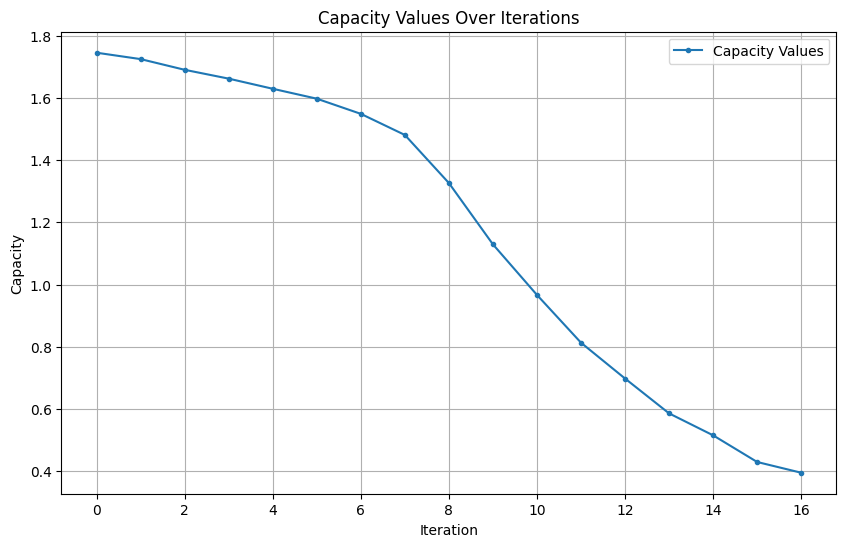

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(iteration_range, extracted_capacity_values, label='Capacity Values', marker='.')
plt.xlabel('Iteration')
plt.ylabel('Capacity')
plt.legend()
plt.title('Capacity Values Over Iterations')
plt.grid(True)

plt.show()

### Save the graph data
this code is saving the data of the graphs for later use 
how to use
-  If you are using it first time  clear the data in `extracted_capacity_values.csv`
- first get your desired output on the above graph
- run this code only once
- it will store it in csv that you can later use to display all graphs at one

In [ ]:
csv_filename = "extracted_capacity_values_2.csv"

with open(csv_filename, 'a', newline='') as csvfile:
    values_as_string = ",".join(map(str, extracted_capacity_values))
    csvfile.write(values_as_string + "\n")

print(f"Values have been appended to the CSV file '{csv_filename}'")

### Ploting all Cell Data
This will take csv of the above code block and plot all the data that is stored aleady

In [ ]:
csv_file = 'extracted_capacity_values_2.csv'

csvdf = pd.read_csv(csv_file, header=None)

num_rows, num_columns = csvdf.shape

for row in range(num_rows):
    plt.plot(csvdf.iloc[row], label=f'Cell {row + 1}')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

plt.show()

# 3 Volatge Charging analysis

### Ploting Voltage
`data_extract` is the array of `(dataframe,starttime)`
- `starttime` is  the that you will place manully by using data above code output
- try to use first most value of the repected data frame if it is not working use the last one or randomly
- you can look above 35 graphs to figure out the proper value of  `starttime`
- `dataframe` is the correct that you want to include in the ploting 

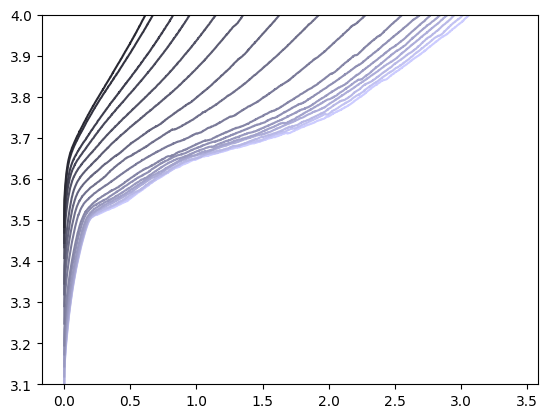

In [17]:
columns_to_plot = [15] 

plt1 = plt
i=0

for i,dataframe in enumerate(filtered_dataframes):
    if i not in skip_indices:
        start_time = filtered_dataframes[i].iloc[0]['Zeit']
        plot_threshold_same_plot(columns_to_plot, filtered_dataframes[i], start_time, start_time+4, plt1, y_min=3.1, y_max=4,i=i)
    else:
        print("Skipping index: ",i)
i=i+1

plt1.show()

### Croping Data

In [10]:
import os
import csv

output_directory = "extracted_data"
os.makedirs(output_directory, exist_ok=True)

In [18]:
min_time = 3.1
max_time = 3.9
time_interval = 0.1

for current_time in np.arange(min_time, max_time + time_interval, time_interval):
    csv_filename = os.path.join(output_directory, f"extracted_voltage_data_{current_time:.1f}.csv")

    I = 0
    for index, dataframe in enumerate(filtered_dataframes):
        if index in skip_indices:
            print(f"Skipping index: {index}")
            continue

        voltage = dataframe['Spannung']
        voltage_mask = (dataframe['Spannung'] >= current_time) & (dataframe['Spannung'] <= current_time + 1)
        voltage = voltage[voltage_mask]
        voltage = voltage.to_numpy()

        if not voltage.size:
            continue

        voltage_range = np.linspace(voltage.min(), voltage.max(), num=50)

        data = {'Spannung{}'.format(i + 1): value for i, value in enumerate(voltage_range)}
        data['Capacity'] = max_values_list[I][0]

        with open(csv_filename, 'a', newline='') as csv_file:
            writer = csv.DictWriter(csv_file, fieldnames=data.keys())
            # if index == 0:
            #     writer.writeheader()
            writer.writerow(data)

        I += 1

    print(f"Saved CSV file: {csv_filename}")

Saved CSV file: extracted_data\extracted_voltage_data_3.1.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.2.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.3.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.4.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.5.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.6.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.7.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.8.csv
Saved CSV file: extracted_data\extracted_voltage_data_3.9.csv
